In [ ]:
import requests

In [ ]:
# Téléchargement du fichier tesseract-ocr
r = requests.get("https://raw.githubusercontent.com/tesseract-ocr/tessdata/4.00/ind.traineddata", stream = True)  

In [ ]:
# Installation des bibliothèques requises pour la reconnaissance optique de caractères
! apt install tesseract-ocr libtesseract-dev libmagickwand-dev
from IPython.display import HTML, clear_output

In [ ]:
# Installation de pytesseract et opencv
! pip install pytesseract wand opencv-python
clear_output()

In [1]:
# Importation de bibliothèques
from PIL import Image
import pytesseract
import cv2 as cv
import numpy as np
from pytesseract import Output
import re

In [ ]:
# 
import urllib.request
def url_to_image(url):
	# download the image, convert it to a NumPy array, and then read
	# it into OpenCV format
	resp = urllib.request.urlopen(url)
	image = np.asarray(bytearray(resp.read()), dtype="uint8")
	image = cv.imdecode(image, cv.IMREAD_COLOR)
	# return the image
	return image

In [12]:
a = cv.imread('tst.jpeg')

In [5]:
cv.imshow('image a', a)
cv.waitKey(0)

-1

In [6]:
## Normalisation de l'image

norm_img = np.zeros((800, 800))
normalisation = cv.normalize(a, norm_img, 0, 255, cv.NORM_MINMAX)
#cv.imwrite('test_normalisation.png',normalisation)



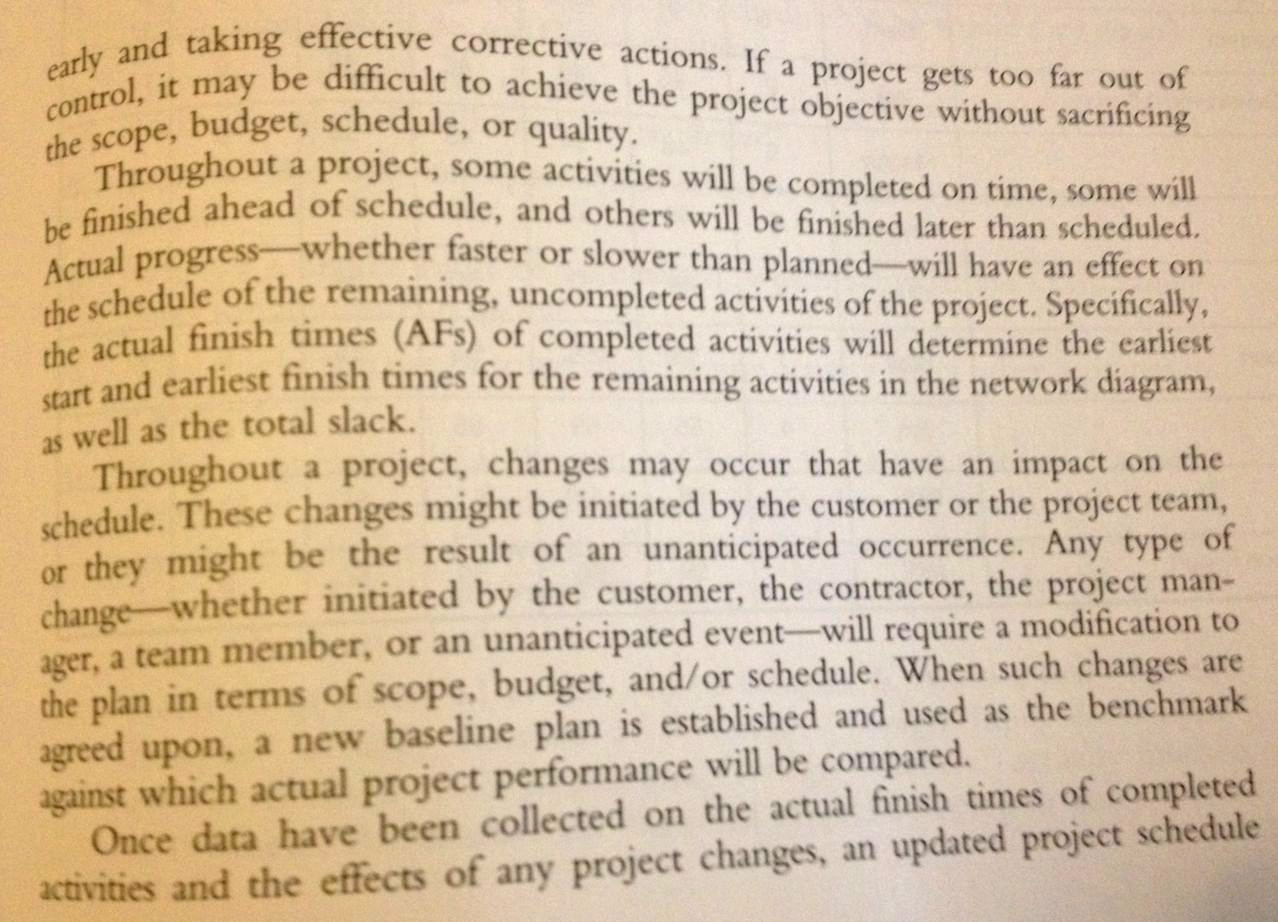

-1

In [ ]:
cv2_imshow(normalisation)
cv.waitKey(0)

In [ ]:
## Redimensionnement de l'image

In [ ]:
#pourcentage de redimensionnement de l'image
scale_percent = 50

#calculer les 50 pour cent des dimensions d'origine
width = int(a.shape[1] * scale_percent / 100)
height = int(a.shape[0] * scale_percent / 100)

# dsize
dsize = (width, height)

# redimensionnement de l'image
redimensionnement = cv.resize(a, dsize)

cv.imwrite('test_redimensionnement.png',redimensionnement) 

True

(461, 639, 3)


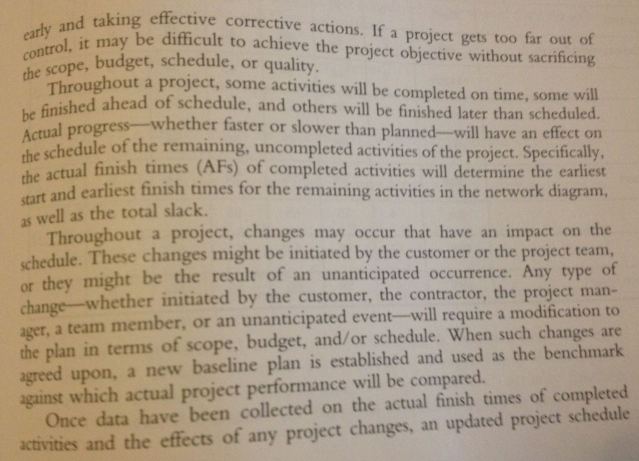

-1

In [ ]:
print(redimensionnement.shape)

cv2_imshow(redimensionnement)
cv.waitKey(0)

In [8]:
# get grayscale image

def get_grayscale(image):
    return cv.cvtColor(image, cv.COLOR_BGR2GRAY)

grayscale = get_grayscale(normalisation)
cv.imwrite('test_grayscale.png',grayscale) 

True

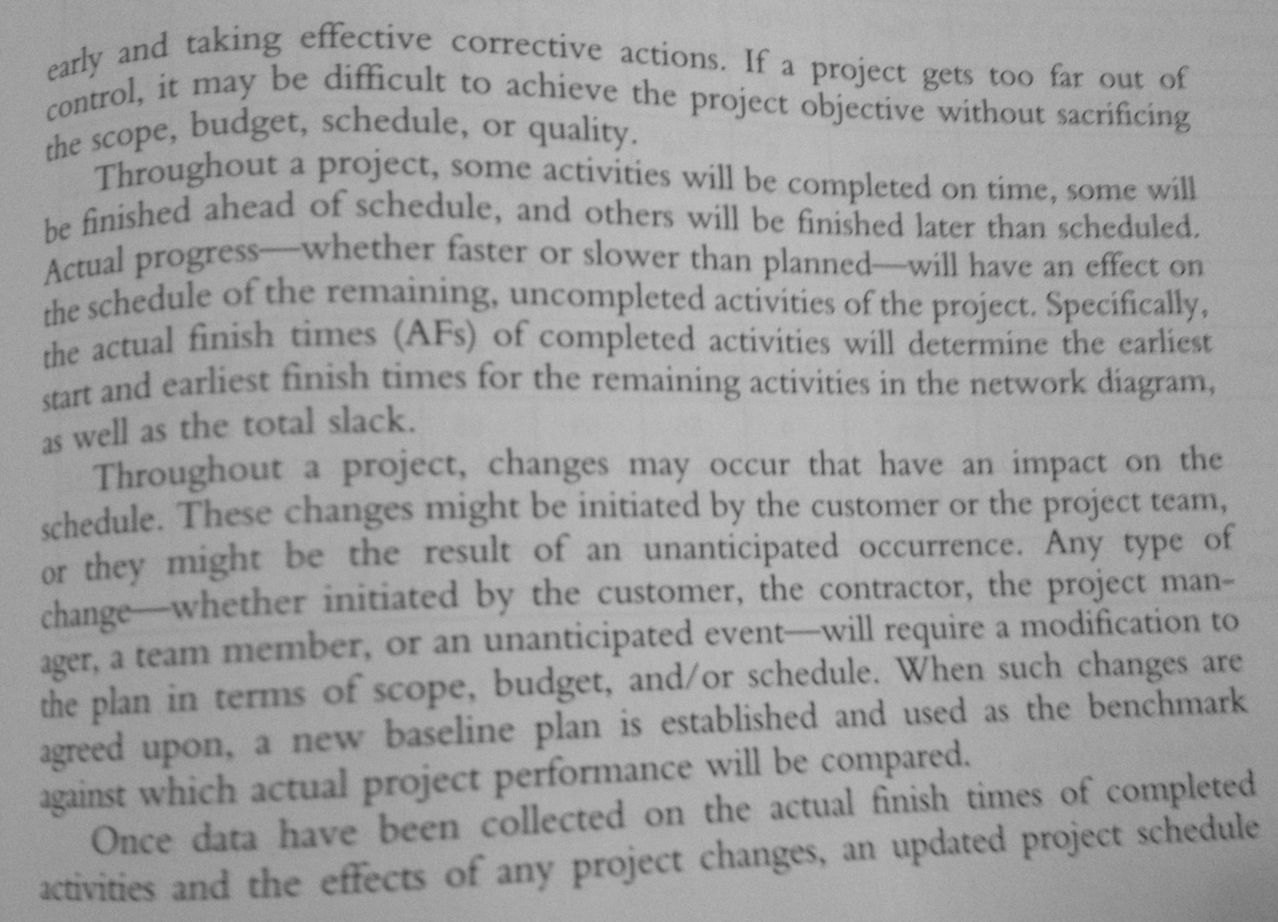

-1

In [ ]:
cv2_imshow(grayscale)
cv.waitKey(0)

In [ ]:
# noise removal

def remove_noise(image):
    return cv.medianBlur(image,5)

noise = remove_noise(a)
cv.imwrite('test_remove_noise.png',noise)     

True

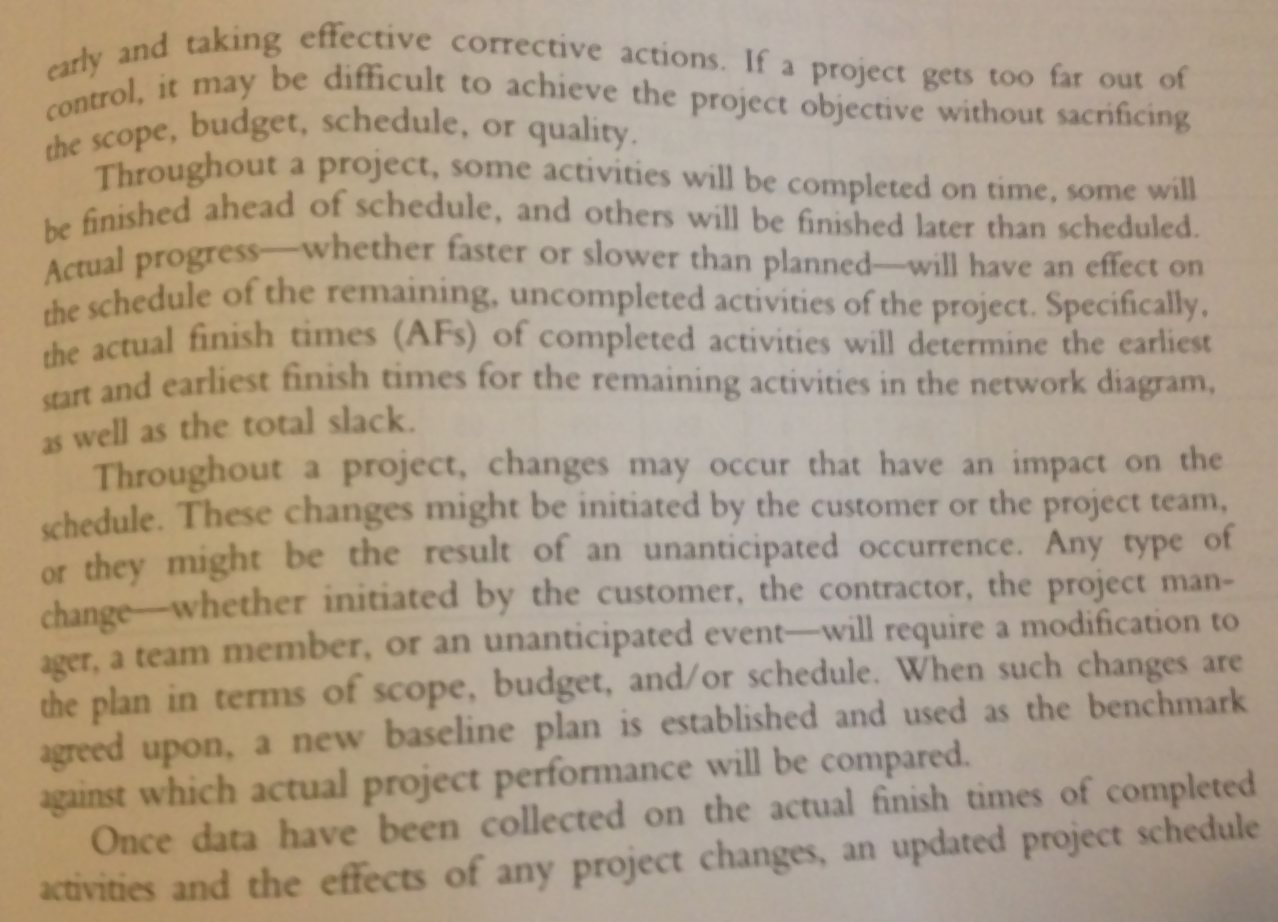

-1

In [ ]:
cv2_imshow(noise)
cv.waitKey(0)

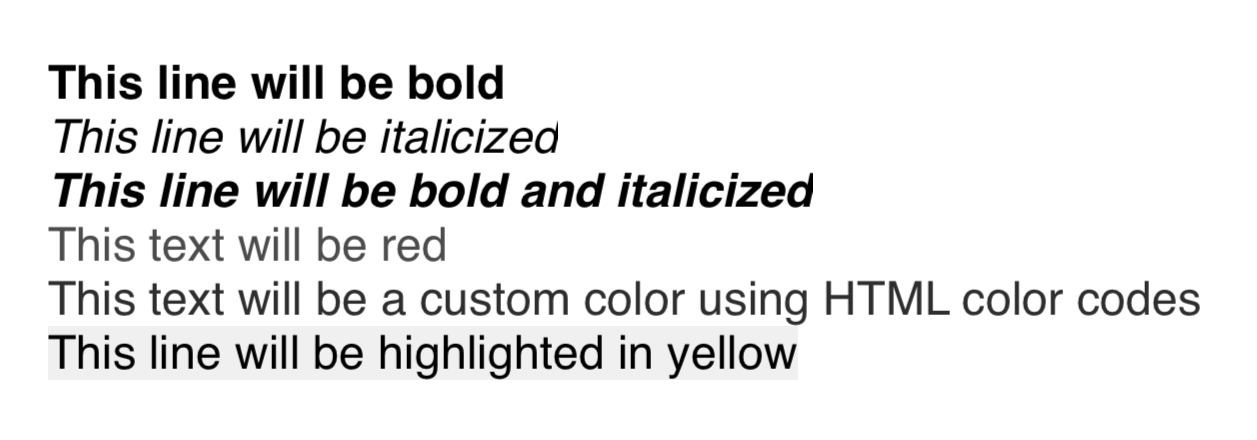

-1

In [ ]:
# Binarisation
bina = url_to_image('http://onsongapp.s3.amazonaws.com/manual/f19a7269ae17477a2ccf542404cdd766.png')
g = get_grayscale(bina)
cv2_imshow(g)
cv.waitKey(0)

In [ ]:
thresh, binarisation = cv.threshold(g, 127, 255, cv.THRESH_BINARY)
cv.imwrite('test_binarisation.png',binarisation) 

True

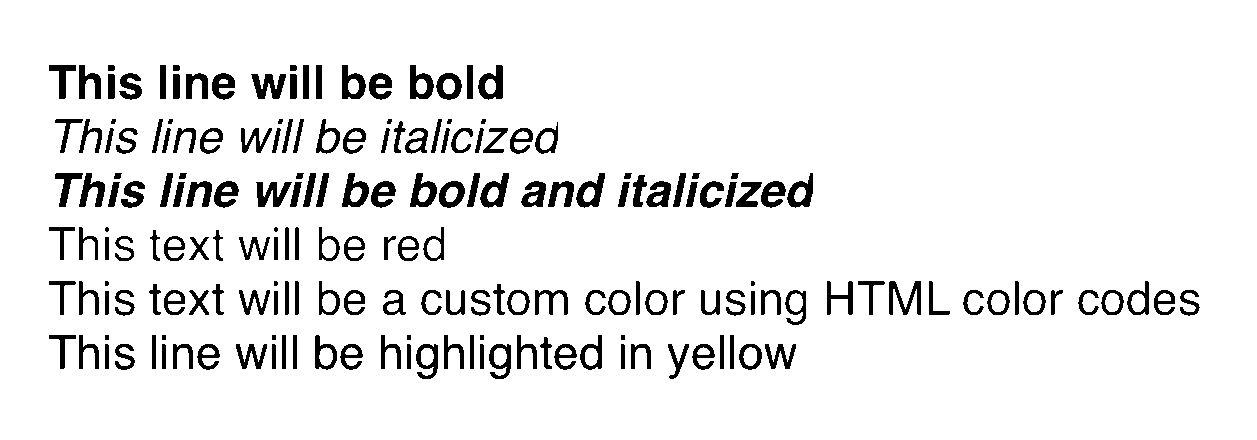

-1

In [ ]:
cv2_imshow(binarisation)
cv.waitKey(0)

In [10]:
from scipy.ndimage import interpolation as inter

def findScore(img, angle):
    data = inter.rotate(img, angle, reshape = False, order = 0)
    hist = np.sum(data, axis = 1)
    score = np.sum((hist[1:] - hist[:-1]) ** 2)
    return hist, score

def skewCorrect(img):
    img = cv.resize(img, (0, 0), fx = 0.75, fy = 0.75)

    delta = 1
    limit = 45
    angles = np.arange(-limit, limit+delta, delta)
    scores = []
    for angle in angles:
        hist, score = findScore(img, angle)
        scores.append(score)
    bestScore = max(scores)
    bestAngle = angles[scores.index(bestScore)]
    rotated = inter.rotate(img, bestAngle, reshape = False, order = 0)
    #print("[INFO] angle: {:.3f}".format(bestAngle))

    return rotated

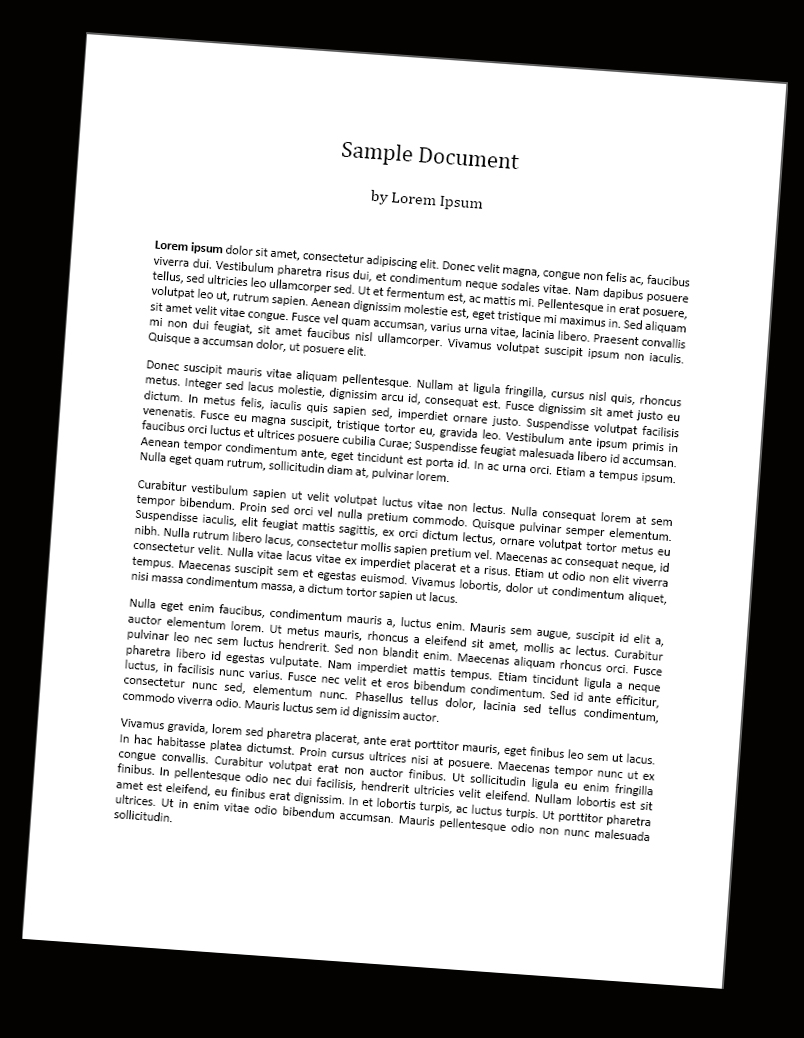

-1

In [ ]:
b = url_to_image('https://www.highmotionsoftware.com/images/imbatch/imbatch_deskew3_sample1.jpg')
cv2_imshow(b)
cv.waitKey(0)

[INFO] angle: 4.000


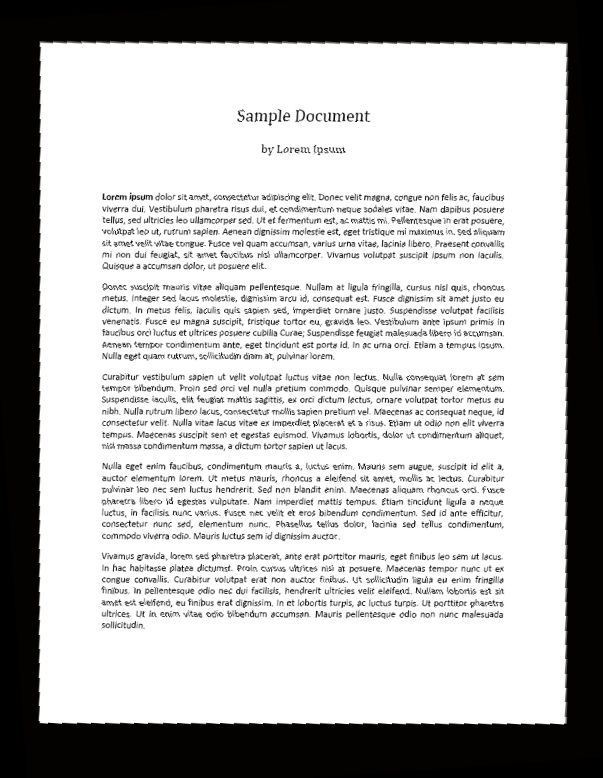

-1

In [ ]:
skew= skewCorrect(b)
cv2_imshow(skew)
cv.waitKey(0)

# Combinaison des methode de pré-traitement

In [30]:
def pre_processing(im):
    ## Normalisation de l'image
    norm_img = np.zeros((800, 800))
    normalisation = cv.normalize(im, norm_img, 0, 255, cv.NORM_MINMAX)
    
    
    # redimensionnement de l'image
    #pourcentage de redimensionnement de l'image
    scale_percent = 50
    #calculer les 50 pour cent des dimensions d'origine
    width = int(a.shape[1] * scale_percent / 100)
    height = int(a.shape[0] * scale_percent / 100)
    # dsize
    dsize = (width, height)
    redimensionnement = cv.resize(normalisation, dsize)
    
    #Grayscale
    grayscale = cv.cvtColor(redimensionnement, cv.COLOR_BGR2GRAY)
    
    
    # noise removal
    noise = cv.medianBlur(grayscale,5)

    
    #Binerisation
    thresh, binarisation = cv.threshold(noise, 127, 255, cv.THRESH_BINARY)
    
    #skew
    skew= skewCorrect(binarisation)
    
    return skew

In [33]:
a = cv.imread('pas.jpeg')
b = pre_processing(a)
cv.imwrite('noise.png', b)


True

# **Detection du texte** 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


**EAST (Efficient accurate scene text detector)**

In [1]:
import os, sys
import numpy as np
import cv2
import time
from imutils.object_detection import non_max_suppression

def east_detect(img):
    model = cv2.dnn.readNet('frozen_east_text_detection.pb')
    
    # ## Prepare the image
    # use multiple of 32 to set the new img shape
    height, width, _ = img.shape
    new_height = (height//32)*32
    new_width = (width//32)*32
    
    # get the ratio change in width and height
    h_ratio = height/new_height
    w_ratio = width/new_width
    
    blob = cv2.dnn.blobFromImage(img, 1, (new_width, new_height),(123.68, 116.78, 103.94), True, False)
    
    # ## Pass the image to network and extract score and geometry map
    model.setInput(blob)

    model.getUnconnectedOutLayersNames()

    (geometry, scores) = model.forward(model.getUnconnectedOutLayersNames())
    
    # ## Post-Processing
    # <img src="OCR_EAST12.png" width=700 height=400 />
    rectangles = []
    confidence_score = []
    for i in range(geometry.shape[2]):
        for j in range(0, geometry.shape[3]):
        
            if scores[0][0][i][j] < 0.1:
                continue
            
            bottom_x = int(j*4 + geometry[0][1][i][j])
            bottom_y = int(i*4 + geometry[0][2][i][j])
        

            top_x = int(j*4 - geometry[0][3][i][j])
            top_y = int(i*4 - geometry[0][0][i][j])
        
            rectangles.append((top_x, top_y, bottom_x, bottom_y))
            confidence_score.append(float(scores[0][0][i][j]))
            

    # use Non-max suppression to get the required rectangles
    fin_boxes = non_max_suppression(np.array(rectangles), probs=confidence_score, overlapThresh=0.5)

    img_copy = img.copy()
    for (x1, y1, x2, y2) in fin_boxes:

        x1 = int(x1 * w_ratio)
        y1 = int(y1 * h_ratio)
        x2 = int(x2 * w_ratio)
        y2 = int(y2 * h_ratio)
        r = img_copy[y1:y2, x1:x2]
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    return img_copy

In [2]:
img = cv2.imread('bouye.jpg')

In [3]:
cv2.imshow("Detection de Texte", east_detect(img))
cv2.imshow("img avant Detection du texte", img)
cv2.waitKey(0)

-1

# Reconnaissance du texte

In [5]:
import pytesseract as pt
pt.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\Tesseract.exe'

In [8]:
# extracting text from image 
custom_config = r'-l fra+eng --oem 3 --psm 6' 

text = pt.image_to_string(img, config=custom_config)
print(text)

IDENTIFICATION CARD
Name: Geoff Sample
D.0.B: Area manager
1D No: 1238626AB4
Issued: January 2011
Expires: December 2013



# Manipilation du texte

In [22]:
import re

#Nomm = re.search('P<MRT(.+?)<<', text).group(1)
#Prenom = re.search('<<(.+?)<', text).group(1)

Nom = re.search('Name:(.+?)\n', text).group(1)
Id = re.search('No:(.+?)\n', text).group(1)

print("Nom:",Nom)
print("Id:", Id)

Nom:  Geoff Sample
Id:  1238626AB4
